## Setup

Import necessary modules and dependencies.

In [1]:
!rm -rf data
!mkdir data
!mkdir data/dataset

"rm" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
Sottodirectory o file data gi… esistente.
Sintassi del comando errata.


In [2]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1jwIWW2vuBJVO-XcCTL9HgmcolCfQJ2ir'    
download_file_from_google_drive(file_id, "data/data.zip")

In [3]:
from zipfile import ZipFile
zf = ZipFile('data/data.zip', 'r')
zf.extractall('data/dataset')
zf.close()

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


# Set seed 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#check if gpu is used
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
data_dir = pathlib.Path("data/dataset/data_final")

Check basic statistics about the dataset.

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
n_classes= len(commands)
print('Commands:', commands)

Commands: ['Alces_alces' 'Bos_taurus' 'Cervus_elaphus' 'Equus_caballus'
 'Lutra_lutra' 'Ovis' 'Pan' 'Panthera_leo' 'Procyon' 'Vulpes']


Extract the audio files into a list and shuffle it.

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 652
Number of examples per label: 48
Example file tensor: tf.Tensor(b'data\\dataset\\data_final\\Ovis\\19.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [5]:
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.9)]
test_files = filenames[-int(num_samples*0.1):]

print('Training set size', (train_files.shape[0]))
print('Validation set size', (val_files.shape[0]))
print('Test set size', (test_files.shape[0]))

Training set size 521
Validation set size 65
Test set size 65


## Reading audio files and their labels

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [10]:
waveform_ds

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>

Let's examine a few audio waveforms with their corresponding labels.

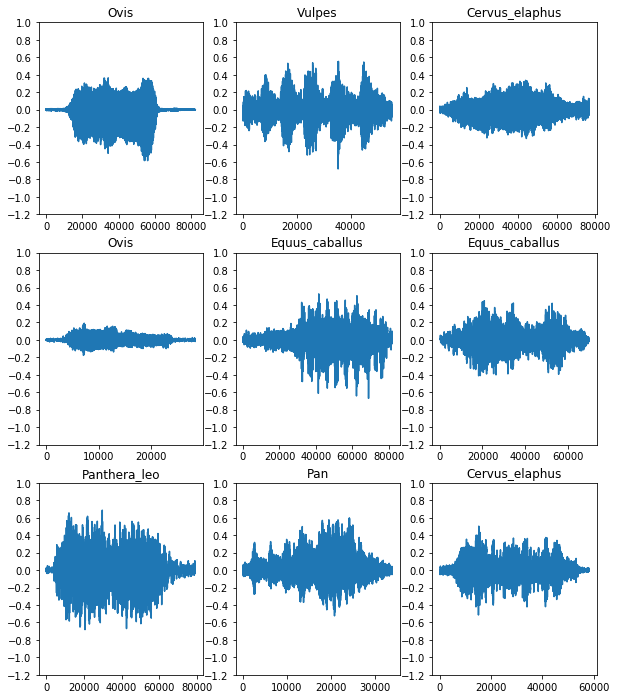

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram




In [12]:
frame_length = 255
frame_step = 255
num_mel_bins = 500
num_spectrogram_bins = (frame_length // 2) + 1
fmin = 0.0
sample_rate = 44100
fmax = sample_rate / 2

In [13]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([140000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    magnitude_spectrograms  = tf.signal.stft(
      equal_length, frame_length, frame_step)
    magnitude_spectrograms  = tf.abs(magnitude_spectrograms)
    
    # Step: magnitude_spectrograms->mel_spectrograms
    # Warp the linear-scale, magnitude spectrograms into the mel-scale.
    num_spectrogram_bins = magnitude_spectrograms.shape[-1]


    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, fmin,
        fmax)

    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    #mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    #  log_mel_spectrograms)[..., :75]
  
    return log_mel_spectrograms

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [14]:
for waveform, label in waveform_ds.take(147):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

InternalError: Blas GEMM launch failed : a.shape=(549, 129), b.shape=(129, 500), m=549, n=500, k=129 [Op:MatMul]

In [ ]:
def plot_spectrogram(spectrogram):
  fig, ax = plt.subplots(figsize=(20,20))
  mfcc_data= np.swapaxes(spectrogram, 0 ,1)
  cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
  ax.set_title('Spectrogram')

plot_spectrogram(spectrogram)
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [15]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  spectrogram = tf.image.grayscale_to_rgb(spectrogram)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [20]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [23]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)


Input shape: (549, 75, 3)


In [26]:
#base_net = inception_v3.InceptionV3(weights="imagenet", include_top=False,
#	input_shape=input_shape, pooling="avg")

In [27]:
#for layer in base_net.layers:
#    layer.trainable = False

In [28]:
#Output of the base_net model
#x = base_net.output
# intermediate fully-connected layer + ReLU
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
# final fully-connected layer + SoftMax 
#pred = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

In [29]:
#model = tf.keras.Model(inputs=base_net.input, outputs=pred)

In [30]:
model1 = models.Sequential(
    [
        layers.Input(shape = input_shape),
        preprocessing.Resizing(32, 32), 
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
        layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
        layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(commands), activation='softmax')
    ]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        3

In [31]:
#model2 = 



In [32]:
model = model1

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [34]:
checkpoint_filepath = "model_weights4.hdf5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
EPOCHS = 300
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS, callbacks=[model_checkpoint_callback]
)

Epoch 1/300
9/9 [==============================] - 1s 116ms/step - loss: 2.2607 - accuracy: 0.1873 - val_loss: 2.1754 - val_accuracy: 0.2857
Epoch 2/300
9/9 [==============================] - 0s 14ms/step - loss: 2.2383 - accuracy: 0.2191 - val_loss: 2.1754 - val_accuracy: 0.2857
Epoch 3/300
9/9 [==============================] - 0s 18ms/step - loss: 2.2284 - accuracy: 0.2332 - val_loss: 2.1387 - val_accuracy: 0.3143
Epoch 4/300
9/9 [==============================] - 0s 16ms/step - loss: 2.2064 - accuracy: 0.2544 - val_loss: 2.1449 - val_accuracy: 0.3143
Epoch 5/300
9/9 [==============================] - 0s 14ms/step - loss: 2.2067 - accuracy: 0.2544 - val_loss: 2.1367 - val_accuracy: 0.3143
Epoch 6/300
9/9 [==============================] - 0s 15ms/step - loss: 2.2025 - accuracy: 0.2580 - val_loss: 2.1439 - val_accuracy: 0.3143
Epoch 7/300
9/9 [==============================] - 0s 17ms/step - loss: 2.2047 - accuracy: 0.2544 - val_loss: 2.1450 - val_accuracy: 0.3143
Epoch 8/300
9/9 [==

Epoch 117/300
9/9 [==============================] - 0s 15ms/step - loss: 1.8608 - accuracy: 0.5972 - val_loss: 1.9458 - val_accuracy: 0.5143
Epoch 118/300
9/9 [==============================] - 0s 15ms/step - loss: 1.8281 - accuracy: 0.6325 - val_loss: 1.9590 - val_accuracy: 0.4857
Epoch 119/300
9/9 [==============================] - 0s 15ms/step - loss: 1.8367 - accuracy: 0.6254 - val_loss: 1.9232 - val_accuracy: 0.5429
Epoch 120/300
9/9 [==============================] - 0s 17ms/step - loss: 1.8315 - accuracy: 0.6360 - val_loss: 1.9197 - val_accuracy: 0.5429
Epoch 121/300
9/9 [==============================] - 0s 15ms/step - loss: 1.7829 - accuracy: 0.6855 - val_loss: 1.9041 - val_accuracy: 0.5714
Epoch 122/300
9/9 [==============================] - 0s 16ms/step - loss: 1.8224 - accuracy: 0.6466 - val_loss: 1.9368 - val_accuracy: 0.5143
Epoch 123/300
9/9 [==============================] - 0s 15ms/step - loss: 1.8050 - accuracy: 0.6572 - val_loss: 1.9433 - val_accuracy: 0.5143
Epoch 

Epoch 175/300
9/9 [==============================] - 0s 15ms/step - loss: 1.6955 - accuracy: 0.7668 - val_loss: 1.9100 - val_accuracy: 0.5714
Epoch 176/300
9/9 [==============================] - 0s 15ms/step - loss: 1.6781 - accuracy: 0.7915 - val_loss: 1.8956 - val_accuracy: 0.5714
Epoch 177/300
9/9 [==============================] - 0s 15ms/step - loss: 1.6623 - accuracy: 0.8021 - val_loss: 1.8653 - val_accuracy: 0.6000
Epoch 178/300
9/9 [==============================] - 0s 17ms/step - loss: 1.6759 - accuracy: 0.7880 - val_loss: 1.9060 - val_accuracy: 0.5429
Epoch 179/300
9/9 [==============================] - 0s 19ms/step - loss: 1.6587 - accuracy: 0.8057 - val_loss: 1.9038 - val_accuracy: 0.5429
Epoch 180/300
9/9 [==============================] - 0s 16ms/step - loss: 1.6539 - accuracy: 0.8092 - val_loss: 1.8986 - val_accuracy: 0.5714
Epoch 181/300
9/9 [==============================] - 0s 15ms/step - loss: 1.6745 - accuracy: 0.7915 - val_loss: 1.8665 - val_accuracy: 0.6000
Epoch 

Epoch 233/300
9/9 [==============================] - 0s 16ms/step - loss: 1.6308 - accuracy: 0.8339 - val_loss: 1.8132 - val_accuracy: 0.6571
Epoch 234/300
9/9 [==============================] - 0s 17ms/step - loss: 1.6316 - accuracy: 0.8339 - val_loss: 1.8357 - val_accuracy: 0.6286
Epoch 235/300
9/9 [==============================] - 0s 17ms/step - loss: 1.6117 - accuracy: 0.8551 - val_loss: 1.8630 - val_accuracy: 0.5714
Epoch 236/300
9/9 [==============================] - ETA: 0s - loss: 1.6219 - accuracy: 0.84 - 0s 17ms/step - loss: 1.6219 - accuracy: 0.8445 - val_loss: 1.8551 - val_accuracy: 0.6000
Epoch 237/300
9/9 [==============================] - 0s 17ms/step - loss: 1.6329 - accuracy: 0.8339 - val_loss: 1.8560 - val_accuracy: 0.6000
Epoch 238/300
9/9 [==============================] - 0s 17ms/step - loss: 1.6174 - accuracy: 0.8410 - val_loss: 1.8677 - val_accuracy: 0.6000
Epoch 239/300
9/9 [==============================] - 0s 16ms/step - loss: 1.6221 - accuracy: 0.8445 - val_

Let's check the training and validation loss curves to see how your model has improved during training.

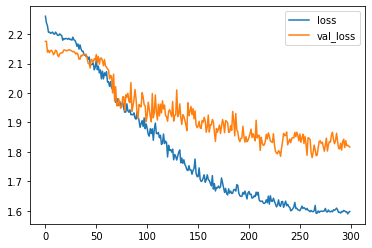

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [37]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [38]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 54%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

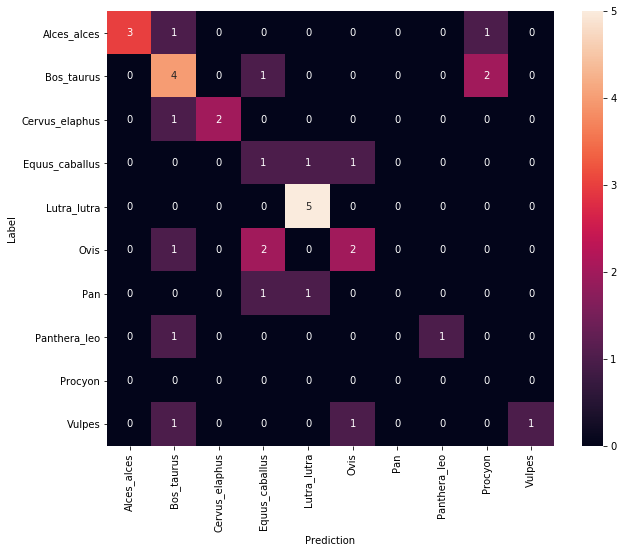

In [39]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file


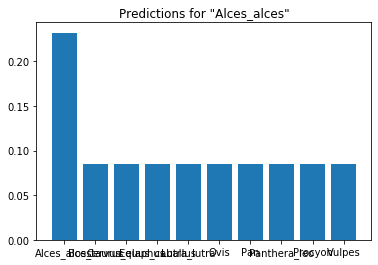

In [40]:
sample_file = test_files[2].numpy().decode("UTF-8")

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()